In [1]:
import os, os.path
import numpy as np
from time import time
import pandas as pd
import math as m
import setup_runs as sr
import importlib
import matplotlib.pyplot as plt

In [5]:
df_attribute_master_id = pd.read_csv(sr.fp_csv_attribute_master)
#temp overwrite
df_master_exp = df_attribute_master_id[(df_attribute_master_id["design_id"] == 0)]
#set gams vals
df_master_exp_gams = df_master_exp[df_master_exp["strategy_id"] > 0]
df_master_exp_gams[["master_id"]].to_csv(sr.fp_csv_experimental_design_msec_masters_to_run_gams, index = None, encoding = "UTF-8")


In [130]:
if False:
    results = pd.read_csv(sr.fp_csv_output_multi_sector)
    #get total demand
    results["all-electricity_total_demand-gwh"] = results[[x for x in results.columns if ("electricity_total_demand" in x)]].sum(axis = 1)
    #reduce to total demand
    df_demand = results[["master_id", "year", "all-electricity_total_demand-gwh"]].copy().rename(columns = {"all-electricity_total_demand-gwh": "Total", "year": "Year"})
else:
    df_demand = pd.read_csv("/Volumes/[C] syme-j-PVM.hidden/Users/jsyme/Desktop/MultiSector_LTS_Chile-master_20201030/MultiSector_LTS_Chile-master_20201030/MultiSector_LTS_Chile-master/out/electric_demand_sectors.csv")
    df_demand["Total"] = df_demand[[x for x in df_demand.columns if (x not in ["master_id", "year"])]].sum(axis = 1)
    df_demand = df_demand.rename(columns = {"year": "Year"})


In [136]:
#get total demand
results["all-electricity_total_demand-gwh"] = results[[x for x in results.columns if ("electricity_total_demand" in x)]].sum(axis = 1)
#reduce to total demand
df_demand = results[["master_id", "year", "all-electricity_total_demand-gwh"]].copy().rename(columns = {"all-electricity_total_demand-gwh": "Total", "year": "Year"})

if False:
    # Se leen los archivos CSV y se guardan como dataframes
    df_duration = pd.read_csv(sr.fp_csv_gams_data_duration)
    df_distr_bloq = pd.read_csv(sr.fp_csv_gams_distribution_by_bloq)
    df_distr_bus = pd.read_csv(sr.fp_csv_gams_shared_by_bus)
else:
    df_duration = pd.read_csv(os.path.join(dir_gm, os.path.basename(sr.fp_csv_gams_data_duration)))
    df_distr_bloq = pd.read_csv(os.path.join(dir_gm, os.path.basename(sr.fp_csv_gams_distribution_by_bloq)))
    df_distr_bus = pd.read_csv(os.path.join(dir_gm, os.path.basename(sr.fp_csv_gams_shared_by_bus)))
#clean
df_distr_bus = df_distr_bus.rename(columns = {"Agno": "Year"})
#get
all_master = list(df_demand['master_id'].unique())
all_master.sort()
# Se define como parametro la cantidad de annos
years = len(df_demand["Year"].unique())
# Se extraen los nombres de las barras
bus_1 = df_distr_bus.iloc[0][0]
bus_2 = df_distr_bus.iloc[1][0]
# Se filtra el dataframe que contiene los porcentajes de distribucion de la demanda entre las barras en un dataframe por barra
df_distr_bus_1 = df_distr_bus[df_distr_bus['Bus'] == bus_1].reset_index(drop = True)
df_distr_bus_2 = df_distr_bus[df_distr_bus['Bus'] == bus_2].reset_index(drop = True)

#build master id
df_master_id = df_demand[['master_id', 'Year']].copy()

##  BUILD DEMAND BY BUS
fields_index = ["master_id", "Year"]
df_demand_by_bus = df_distr_bus.copy()
#merge in total demand
df_demand_by_bus = pd.merge(df_demand, df_demand_by_bus, how = "outer", on = ["Year"])
# Se multiplican las columnas de la demanda total con la columna del dataframe con los porcentajes por barras y se colocan en la columna del dataframme
df_demand_by_bus["valor"] = np.array(df_demand_by_bus["Shared_by_bus"])*np.array(df_demand_by_bus["Total"])
#set to wide format
df_demand_by_bus = df_demand_by_bus[fields_index + ["Bus", "valor"]]
#df_demand_by_bus = sr.data_to_wide(df_demand_by_bus, "Bus", "valor", fields_index, False) 
df_demand_by_bus = df_demand_by_bus.sort_values(by = fields_index)

#get duration by block
df_duration = df_duration.rename(columns = {'Agno': 'Year'})
df_distr_bloq = df_distr_bloq.merge(df_duration, on = ['Year', 'Etapa', 'Bloque'], how = 'left')

#get all demand data merged
df_data_demanda = pd.merge(df_demand_by_bus, df_distr_bloq, how = "outer", on = ["Year", "Bus"]).rename(columns = {"valor": "Demanda_Barra_Agno"})

# Se obtienen las columnas que son la multiplicacion de otras columnas
df_data_demanda['Potencia_Bloque'] = 1000*np.array(df_data_demanda['Distribucion_Bloque']) * np.array(df_data_demanda['Distribucion_Etapa']) * np.array(df_data_demanda['Demanda_Barra_Agno'])/np.array(df_data_demanda['Duracion'])
df_out = df_data_demanda[['master_id', 'Bus','Year', 'Etapa', 'Bloque', 'Potencia_Bloque']] 
df_out = df_out.rename(columns = {'master_id':'Escenario', 'Bus':'Barra', 'Year':'Agno', 'Potencia_Bloque':'Demanda'})
#export
df_out.to_csv(sr.fp_csv_gams_data_demanda_electrica_escenarios, index = False, encoding = "UTF-8")



In [170]:
df_esc = pd.read_csv(os.path.join(sr.dir_gams_input, "data_set_escenarios.csv"))





In [179]:
ld = os.listdir(sr.dir_gams_input)
ld = [x for x in ld if ".csv" in x]
dict_check = {}

for x in ld:
    df_tmp = pd.read_csv(os.path.join(sr.dir_gams_input, x))
    cols_check = [k for k in df_tmp.columns if ("Escenario" in k)]
    
    if len(cols_check) > 0:
        dict_check.update({x: df_tmp})

In [180]:
dict_check.keys()

dict_keys(['data_precio_energeticos_escenarios.csv', 'data_set_escenario_sel.csv', 'data_demanda_electrica_escenarios.csv', 'data_demanda_electrica_escenarios_base.csv', 'data_set_escenarios.csv', 'data_costo_inversion_procesos_escenarios.csv'])

In [191]:
dt = dict_check["data_precio_energeticos_escenarios.csv"]
dt_wide = sr.data_to_wide(dt, "Escenario", "Precio", ["Agno", "Energeticos"], False)
dt_wide[dt_wide["Agno"] == 2050]

,Agno,Energeticos,0,1,2,3,4,5,6,7,...,34,35,36,37,38,39,40,41,42,43
35,2050,carbon_generacion,70.792786,75.409616,66.594132,61.006074,59.633327,57.410356,70.875558,75.870811,...,63.024871,63.889010,71.957743,69.166541,64.009299,72.923214,56.966988,67.974546,55.947994,68.764009
71,2050,gas_natural_generacion,8.676578,10.072485,8.956924,9.439149,9.186438,10.203122,11.809680,9.313034,...,10.669214,8.927483,11.380875,10.288803,11.790642,9.161901,10.751672,8.499649,11.831310,10.725380
107,2050,diesel_generacion,659.654418,583.365932,616.533779,665.842714,587.820810,706.135072,673.923032,703.790937,...,680.082198,609.457029,718.282770,839.145391,654.493493,795.870967,902.584242,845.626587,794.209392,924.874595
143,2050,fuel_oil,543.146109,416.951541,544.820013,569.910084,577.565025,580.456776,538.053659,717.797600,...,571.016912,650.581333,563.353293,657.263617,421.373171,525.503011,433.409429,594.567519,626.615371,519.615761


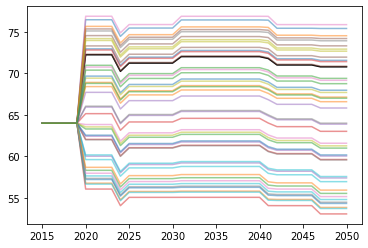

In [205]:
carb = dt_wide[dt_wide["Energeticos"] == "carbon_generacion"]
x = np.array(carb["Agno"])

y = np.array(carb[0])
plt.plot(x, y, alpha = 1, color = "black")
for val in range(1, 44):
    y = np.array(carb[val])
    plt.plot(x, y, alpha = 0.5)
plt.show()
    
    


In [2]:
df_ed = pd.read_csv(sr.fp_csv_experimental_design_msec)
df_ed_sv = pd.read_csv(sr.fp_csv_experimental_design_msec_single_vals)

In [256]:
df_mt = pd.read_csv(sr.fp_csv_parameter_mix_trajectories)
#df_mt["mix_parameter"] = [(x[0] + "_mix") for x in np.array(df_mt[["parameter", "time_serie"]])]
df_params_out = df_mt[["parameter"]].drop_duplicates()
df_params_out["parameter"] = ["trajmix_" + x for x in df_params_out["parameter"]] 
v = sr.build_linear_mix_vec((2019, 2050), (2015, 2050))
df_params_out = pd.concat([df_params_out.reset_index(drop = True), pd.DataFrame([v*0.5 for x in range(len(df_params_out))], columns = range(2015, 2051))], axis = 1)
df_params_out["strategy_id"] = [0 for x in range ]




In [221]:
price_coal = 'fuel_price_coal'
price_gas = 'fuel_price_natural_gas'
price_diesel = 'fuel_price_diesel'
price_oil = 'fuel_price_fuel_oil'

#df_ed[price_coal]

In [249]:
df_mt["mix_parameter"] = [("traj" + x[1] + "_"  + x[0]) for x in np.array(df_mt[["parameter", "traj_type"]])]

In [250]:
df_mt.to_csv("/Users/jsyme/Desktop/tmpmp.csv", index = None, encoding = "UTF-8")

In [258]:
df_params_out.to_csv("/Users/jsyme/Desktop/tmpmp2.csv", index = None, encoding = "UTF-8")

In [259]:
len("test")

4

In [7]:
len(df_ed["master_id"].unique())

44

In [263]:
df_cat_gas = pd.DataFrame(["test" for i in range(36)])

In [302]:
#set ids for different data frames
dict_dfs_exp = {
    "inversion": {"substr": "investment", "exp_path": sr.fp_csv_gams_data_costo_inversion_procesos_escenarios},
    "precio": {"substr": "fuel_price", "exp_path": sr.fp_csv_gams_data_precio_energeticos_escenarios}
}
#loop
for k in list(dict_dfs_exp.keys()):
    #get substring id
    substr_id = str(dict_dfs_exp[k]["substr"])
    #get sub data frame
    df_sub = df_ed[["master_id", "year"] + [x for x in df_ed.columns if (x in sr.dict_map_params_to_params_gams.keys()) and (x[0:min(len(x), len(substr_id))] == substr_id)]].copy()
    #rename
    df_sub = df_sub.rename(columns = sr.dict_map_params_to_params_gams)
    #conver to long and rename
    df_sub = pd.melt(df_sub, ["master_id", "year"]).rename(columns = {"master_id": "Escenario", "year": "Agno", "variable": "Energeticos", "value": "Precio"})
    #export
    df_sub.to_csv(dict_dfs_exp[k]["exp_path"], encoding = "UTF-8", index = None)
    

In [300]:
pd.melt(df_sub, ["master_id", "year"])

,master_id,year,variable,value
0,0,2015,generacion_solar_csp,7332.000000
1,0,2016,generacion_solar_csp,7332.000000
2,0,2017,generacion_solar_csp,7332.000000
3,0,2018,generacion_solar_csp,7332.000000
4,0,2019,generacion_solar_csp,7332.000000
...,...,...,...,...
2875,15,2046,generacion_eolica,1037.217581
2876,15,2047,generacion_eolica,1038.075469
2877,15,2048,generacion_eolica,1038.798673
2878,15,2049,generacion_eolica,1039.383947


In [272]:
df_map_param_to_pg = pd.read_csv(sr.fp_csv_map_parameter_to_gams)
sr.build_dict(df_map_param_to_pg[["parameter", "parameter_gams"]])


{'investment_cost_pv_solar': 'generacion_solar_fv',
 'investment_cost_csp_solar': 'generacion_solar_csp',
 'investment_cost_wind': 'generacion_eolica',
 'investment_cost_geothermal': 'generacion_geotermia',
 'investment_cost_natural_gas_cc': 'generacion_gas_natural_cc',
 'fuel_price_coal': 'carbon_generacion',
 'fuel_price_natural_gas': 'gas_natural_generacion',
 'fuel_price_diesel': 'diesel_generacion',
 'fuel_price_fuel oil': 'fuel_oil'}

In [305]:
pd.DataFrame([[1]], columns = ["Test"])

,Test
0,1


In [306]:
df_attribute_master = pd.read_csv(sr.fp_csv_attribute_master)
df_masters_to_run = pd.read_csv(sr.fp_csv_experimental_design_msec_masters_to_run)

In [307]:
df_masters_to_run

,master_id
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7


In [309]:
for m in df_masters_to_run["master_id"]:
    print(list(df_attribute_master["master_id"]).index(m))

0
1
2
3
4
5
6
7


In [313]:
sr.fp_gams_modelo

'/Users/jsyme/Documents/Projects/FY20/SWCHE102-1000/git/MultiSector_LTS_Chile/gams/pmr/modelo/modelo_energetico_PMR_20201009.gms'

In [317]:
print(time.time())
time.sleep(1)
print(time.time())

1605084214.550484
1605084215.556038


In [321]:
results

,master_id,year,co-electricity_total_demand-gwh,co-emissions_total-mtco2e,im-electricity_cement_demand-gwh,im-electricity_copper_demand-gwh,im-electricity_fishing_demand-gwh,im-electricity_iron_demand-gwh,im-electricity_other_industries_demand-gwh,im-electricity_other_mining_demand-gwh,...,tx-electricity_total_demand-gwh,tx-emissions_aviation-mtco2e,tx-emissions_bus-mtco2e,tx-emissions_maritime-mtco2e,tx-emissions_private-mtco2e,tx-emissions_taxi-mtco2e,tx-emissions_total-mtco2e,tx-emissions_train-mtco2e,tx-emissions_truck-mtco2e,all-electricity_total_demand-gwh
0,0,2015,8541.714800,2.309573,1977.247066,24821.075846,156.444138,808.872992,11226.164916,1179.823429,...,416.897254,1.219239,3.288999,0.715503,12.861071,0.591592,26.004890,0.098185,7.230302,71280.371262
1,0,2016,8541.714800,2.309573,1977.247066,24821.075846,156.444138,808.872992,11226.164916,1179.823429,...,421.745181,1.369477,3.336306,0.633547,13.537586,0.598033,26.803220,0.097969,7.230302,71456.469490
2,0,2017,8541.714800,2.309573,1977.247066,24821.075846,156.444138,808.872992,11226.164916,1179.823429,...,457.443650,1.474356,3.371601,0.611322,13.594860,0.606331,26.979861,0.091088,7.230302,71712.696777
3,0,2018,9141.687480,2.471798,2042.861917,25312.768691,156.274456,811.384112,11037.738700,1201.525361,...,502.519510,1.561705,3.349866,0.661311,13.947916,0.631670,27.728720,0.092806,7.483447,73363.792524
4,0,2019,9460.444616,2.557986,2031.207062,26403.522262,156.115441,809.238362,11000.435221,1205.969798,...,686.972091,1.649551,3.229574,0.661174,14.250559,0.641634,28.139906,0.092806,7.614609,75414.978014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,7,2046,49016.330892,5.821199,1635.747787,55804.846780,160.275215,1283.979030,14644.609824,1592.098241,...,11761.227506,7.139901,0.000000,1.107201,17.303847,0.000000,32.973964,0.097717,7.325299,181210.521364
284,7,2047,51547.526395,5.911672,1636.235973,57328.069473,160.580883,1283.996585,14825.646993,1608.684228,...,12718.878245,7.480568,0.000000,1.130393,16.406027,0.000000,32.189571,0.097899,7.074684,187344.373031
285,7,2048,54202.373780,6.000056,1637.997101,58896.737657,160.890392,1284.014130,15010.311900,1625.460201,...,13756.966396,7.832867,0.000000,1.156184,15.386785,0.000000,31.292688,0.098081,6.818772,193884.643269
286,7,2049,56890.119494,6.075730,1637.919756,60510.110841,161.202785,1284.031687,15194.726920,1642.424222,...,14903.039065,8.195161,0.000000,1.179013,14.192654,0.000000,30.217370,0.098262,6.552279,200946.543305


In [365]:
##  BUILD ATTRIBUTE FILE

def set_def(x):
    if dict_field_type[x] == "filter":
        return "all"
    else:
        return ""

#initialize
df_attribute_field = [[x, x.replace("_", " "), dict_field_type[x], set_def(x), 1] for x in dict_field_type.keys()]
#dataframe
df_attribute_field = pd.DataFrame(df_attribute_field, columns = ["field_name", "field_display_name", "field_prim_type", "field_filter_default", "include"])
#convert to integer
df_attribute_field["include"] = np.array(df_attribute_field["include"]).astype(int)




In [367]:
df_prim

,master_id,strategy_id,cement_production,copper_production,cumplimiento_metas,especies_exoticas,especies_nativas,fishing_production,incendio_bosque_nativo,incendio_plantaciones_forestales,...,co-emissions_total-mtco2e,im-emissions_total-mtco2e,pu-emissions_total-mtco2e,re-emissions_total-mtco2e,tx-emissions_total-mtco2e,ag-emissions_total-mtco2e,fo-emissions_total-mtco2e,ip-emissions_total-mtco2e,wa-emissions_total-mtco2e,el-emissions_total-mtco2e
0,0,0,4956.645407,9940.922610,1.000000,6.604015e+06,6.593289e+06,4752.855000,0.0,0.0,...,5.553363,16.170396,0.164441,6.174163,27.798260,10.338088,-61.902828,7.134724,6.738647,2.61
1,1,0,4993.648726,9613.373913,1.027678,7.703721e+06,6.387344e+06,4816.662561,0.0,0.0,...,5.409909,15.898822,0.170353,5.696323,27.704408,10.555351,-59.769188,7.071612,6.714912,2.61
2,2,0,5403.867789,10847.452439,0.842706,5.955067e+06,7.551210e+06,4338.248958,0.0,0.0,...,6.377982,17.054607,0.184280,6.505910,29.816858,10.504467,-63.161910,7.485956,6.877601,2.61
3,3,0,4804.843522,11359.058415,0.852505,5.527154e+06,7.698712e+06,5211.004529,0.0,0.0,...,5.622857,17.409881,0.190467,6.921748,28.032009,10.645824,-63.992144,7.166504,6.749798,NaN
4,4,0,4523.034995,9074.915751,0.996000,7.301031e+06,6.918554e+06,4497.983814,0.0,0.0,...,7.257230,16.218920,0.172748,6.117600,33.590997,10.020470,-60.550484,7.839050,7.015145,NaN
5,5,0,5124.266429,9995.115104,1.017580,5.719108e+06,6.071895e+06,4418.797331,0.0,0.0,...,4.044501,16.026223,0.146274,5.410616,23.340438,10.043008,-63.619717,6.422645,6.435411,NaN
6,6,0,5305.923473,12774.725268,0.882658,6.462246e+06,5.972190e+06,4990.283520,0.0,0.0,...,4.360430,16.931335,0.146231,6.198622,24.665460,10.069487,-62.177887,6.573713,6.509140,NaN
7,7,0,4950.929925,8259.992745,0.912552,7.586024e+06,6.625010e+06,4645.894755,0.0,0.0,...,7.043117,15.374084,0.123994,5.135186,32.005476,10.823919,-59.997542,7.754471,6.979826,NaN
8,8,0,4723.847144,13747.451868,0.808563,6.173330e+06,7.337703e+06,4737.932879,0.0,0.0,...,6.054908,18.382925,0.177158,6.774649,29.031154,10.500809,-62.738438,7.351971,6.827239,NaN
9,9,0,5157.478673,12607.519092,0.958794,6.934167e+06,5.548289e+06,5119.106035,0.0,0.0,...,4.567238,17.429757,0.194899,7.225055,24.163237,9.602113,-61.262270,6.678584,6.552192,NaN


In [2]:
df_ed = pd.read_csv(sr.fp_csv_experimental_design_msec)

In [5]:
df_ed[df_ed["year"] == 2050]["var_demanda_legna"]

35      0.743467
71      0.418056
107     0.894612
143     0.807517
179     0.713338
215     0.492440
251     0.823598
287     0.563963
323     0.976398
359     0.685752
395     0.561043
431     0.743467
467     0.418056
503     0.894612
539     0.807517
575     0.713338
611     0.492440
647     0.823598
683     0.563963
719     0.976398
755     0.685752
791     0.561043
827     0.743467
863     0.418056
899     0.894612
935     0.807517
971     0.713338
1007    0.492440
1043    0.823598
1079    0.563963
1115    0.976398
1151    0.685752
1187    0.561043
1223    0.743467
1259    0.418056
1295    0.894612
1331    0.807517
1367    0.713338
1403    0.492440
1439    0.823598
1475    0.563963
1511    0.976398
1547    0.685752
1583    0.561043
Name: var_demanda_legna, dtype: float64

In [2]:
df_pmr = pd.read_csv(sr.fp_csv_output_multi_sector_pmr)

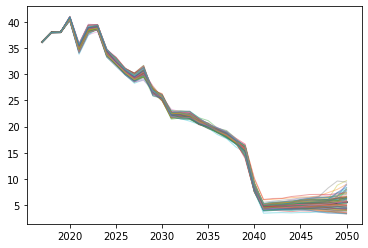

In [13]:
l = list(df_pmr[df_pmr["year"] == 2050]["el-emissions_total-mtco2e"])

ms = list(set(df_pmr["master_id"]))
ms.sort()

x = list(set(df_pmr["year"]))
x.sort()

m = 101
y = list(df_pmr[df_pmr["master_id"] == m]["el-emissions_total-mtco2e"])

plt.plot(x, y, color = "black", alpha = 1, linewidth = 2)

for m in [k for k in ms if x != 101]:
    y = list(df_pmr[df_pmr["master_id"] == m]["el-emissions_total-mtco2e"])
    plt.plot(x, y, alpha = 0.4, linewidth = 1)

plt.show()


In [11]:
y

[]

In [3]:
(0.76)**11

0.048859555885783564

AttributeError: module 'setup_runs' has no attribute 'fp_csv_mapping_year_to_cost_year'